In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import EarlyStopping 
import joblib
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt

2025-05-13 17:43:20.388230: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 17:43:20.427318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [2]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [3]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [4]:
df = df.rename(columns = {"bulk_labels":"cell type"})
categories = df['cell type'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['cell type']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('cell type', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


In [5]:
np.save("categories.npy", categories)
df_features_only = df.drop('cell type', axis=1)
feature_names = df_features_only.columns.to_numpy()
np.save("training_feature_names.npy", feature_names)

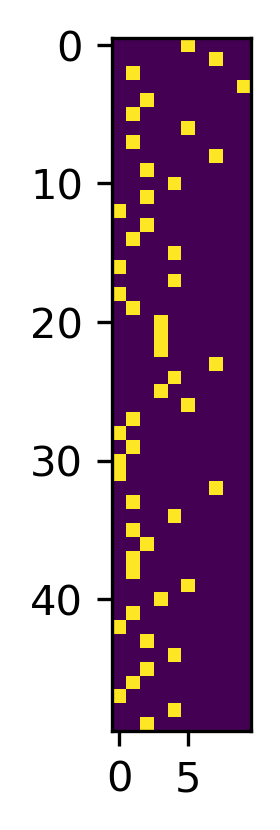

In [6]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [7]:
if 'y_train' not in globals() or 'y_test' not in globals():
    raise NameError("y_train and/or y_test are not defined. Please run the initial data loading script.")

if y_train.ndim == 2 and y_train.shape[1] > 1: 
    y_train_int = np.argmax(y_train, axis=1)
    y_test_int = np.argmax(y_test, axis=1)
    print("Converted y_train and y_test from one-hot to integer labels for scikit-learn classifiers.")
    print(f"y_train_int shape: {y_train_int.shape}, y_test_int shape: {y_test_int.shape}")
    print(f"Original y_train (one-hot) shape: {y_train.shape}")
else: 
    y_train_int = y_train.flatten() if y_train.ndim > 1 else y_train
    y_test_int = y_test.flatten() if y_test.ndim > 1 else y_test
    print("Assuming y_train and y_test are already integer labels or 1D.")

if 'X_train' not in globals() or 'X_test' not in globals():
    raise NameError("X_train and/or X_test are not defined.")

scaler_original_data = MinMaxScaler()
X_train_scaled_orig = scaler_original_data.fit_transform(X_train)
X_test_scaled_orig = scaler_original_data.transform(X_test)

print(f"\nOriginal X_train shape: {X_train.shape}, Scaled X_train_scaled_orig shape: {X_train_scaled_orig.shape}")
print(f"Original X_test shape: {X_test.shape}, Scaled X_test_scaled_orig shape: {X_test_scaled_orig.shape}")

if 'categories' not in globals():
    raise NameError("Variable 'categories' not found.")
print(f"\nCell type categories for classification report: {categories}")
num_classes = len(categories)

Converted y_train and y_test from one-hot to integer labels for scikit-learn classifiers.
y_train_int shape: (560,), y_test_int shape: (140,)
Original y_train (one-hot) shape: (560, 10)

Original X_train shape: (560, 765), Scaled X_train_scaled_orig shape: (560, 765)
Original X_test shape: (140, 765), Scaled X_test_scaled_orig shape: (140, 765)

Cell type categories for classification report: ['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']



--- Training Random Forest on Original Scaled Data ---
Random Forest training on original data complete.

Accuracy on Original Scaled Data: 0.8143

Classification Report on Original Scaled Data:
                              precision    recall  f1-score   support

              CD14+ Monocyte       0.82      0.90      0.86        30
                   Dendritic       0.88      0.88      0.88        50
                    CD56+ NK       0.80      0.67      0.73         6
             CD4+/CD25 T Reg       0.59      1.00      0.74        10
                     CD19+ B       0.94      1.00      0.97        15
            CD8+ Cytotoxic T       0.62      0.57      0.59        14
         CD4+/CD45RO+ Memory       0.00      0.00      0.00         1
CD8+/CD45RA+ Naive Cytotoxic       1.00      0.44      0.62         9
  CD4+/CD45RA+/CD25- Naive T       0.00      0.00      0.00         2
                       CD34+       1.00      0.67      0.80         3

                    accuracy    

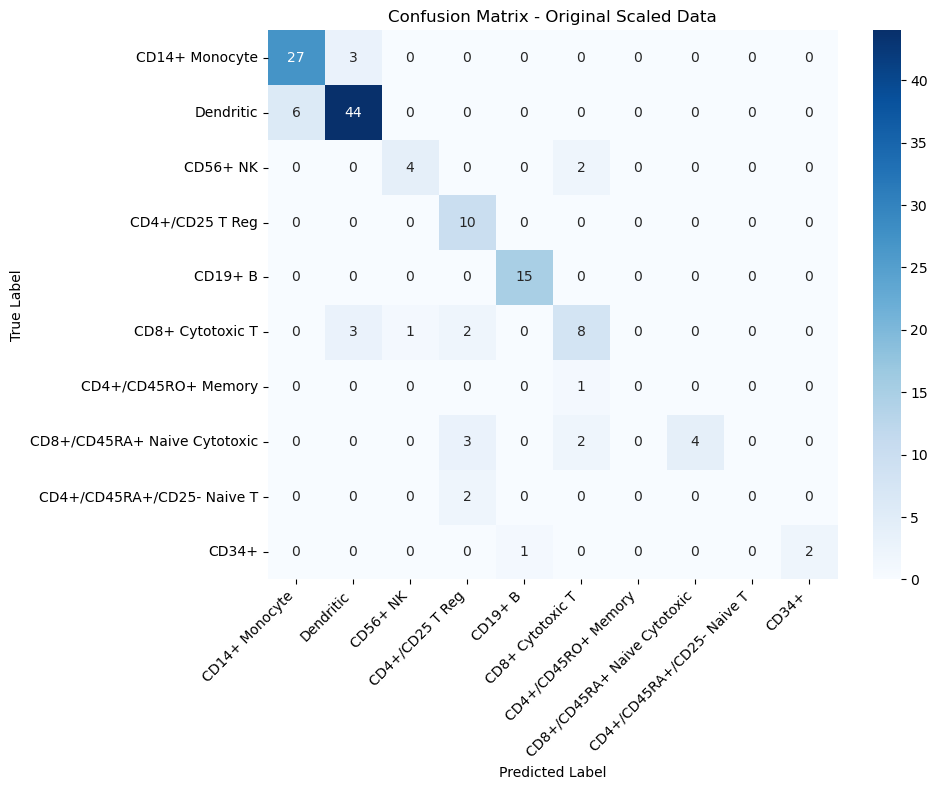

In [8]:
print("\n--- Training Random Forest on Original Scaled Data ---")
rf_classifier_orig = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the classifier
rf_classifier_orig.fit(X_train_scaled_orig, y_train_int)
print("Random Forest training on original data complete.")

# Make predictions on the test set
y_pred_orig = rf_classifier_orig.predict(X_test_scaled_orig)

# Evaluate the classifier
accuracy_orig = accuracy_score(y_test_int, y_pred_orig)
print(f"\nAccuracy on Original Scaled Data: {accuracy_orig:.4f}")

print("\nClassification Report on Original Scaled Data:")
class_report_orig = classification_report(y_test_int, y_pred_orig, target_names=categories, zero_division=0)
print(class_report_orig)

# Confusion Matrix
print("\nConfusion Matrix on Original Scaled Data:")
cm_orig = confusion_matrix(y_test_int, y_pred_orig)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Original Scaled Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
print("\n--- Loading Autoencoder Artifacts from Part 1 ---")
try:
    final_encoder = keras.models.load_model("AE_Latent64_NoL1_L2_Dropout.keras")
    print("Loaded 'final_encoder.keras' successfully.")
    scaler_final = joblib.load("AE_Latent64_NoL1_L2_Dropout.joblib")
    print("Loaded 'scaler_final.joblib' successfully.")
    can_run_latent_classification = True
except IOError as e:
    print(f"Error loading model or scaler: {e}")
    print("Ensure encoder file are in current directory")
    print("Skipping classification on autoencoder latent space.")
    if 'X_train' in globals(): 
        X_train_latent = np.random.rand(X_train.shape[0], 32) 
        X_test_latent = np.random.rand(X_test.shape[0], 32)
    else: # Fallback
        X_train_latent = np.array([])
        X_test_latent = np.array([])
    can_run_latent_classification = False


if can_run_latent_classification:
    print("\nPreparing Data using Autoencoder Latent Space")
    if 'X_train' not in globals() or 'X_test' not in globals():
        raise NameError("X_train and/or X_test (original counts for Part 2) not found. Run Part 2 data loading cell first.")

    X_train_scaled_for_ae = scaler_final.transform(X_train) 
    X_test_scaled_for_ae = scaler_final.transform(X_test) 

    print("Generating latent representations for X_train...")
    X_train_latent = final_encoder.predict(X_train_scaled_for_ae)
    print("Generating latent representations for X_test...")
    X_test_latent = final_encoder.predict(X_test_scaled_for_ae)

    print(f"X_train_latent shape: {X_train_latent.shape}")
    print(f"X_test_latent shape: {X_test_latent.shape}")


--- Loading Autoencoder Artifacts from Part 1 ---
Loaded 'final_encoder.keras' successfully.
Loaded 'scaler_final.joblib' successfully.

Preparing Data using Autoencoder Latent Space
Generating latent representations for X_train...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Generating latent representations for X_test...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
X_train_latent shape: (560, 64)
X_test_latent shape: (140, 64)



Training Random Forest on Autoencoder Latent Space Data
Random Forest training on latent space data complete.

Accuracy on Autoencoder Latent Space Data: 0.7643

Classification Report on Autoencoder Latent Space Data:
                              precision    recall  f1-score   support

              CD14+ Monocyte       0.81      0.83      0.82        30
                   Dendritic       0.85      0.88      0.86        50
                    CD56+ NK       0.71      0.83      0.77         6
             CD4+/CD25 T Reg       0.46      0.60      0.52        10
                     CD19+ B       1.00      0.87      0.93        15
            CD8+ Cytotoxic T       0.80      0.57      0.67        14
         CD4+/CD45RO+ Memory       0.00      0.00      0.00         1
CD8+/CD45RA+ Naive Cytotoxic       0.40      0.44      0.42         9
  CD4+/CD45RA+/CD25- Naive T       0.00      0.00      0.00         2
                       CD34+       1.00      0.67      0.80         3

         

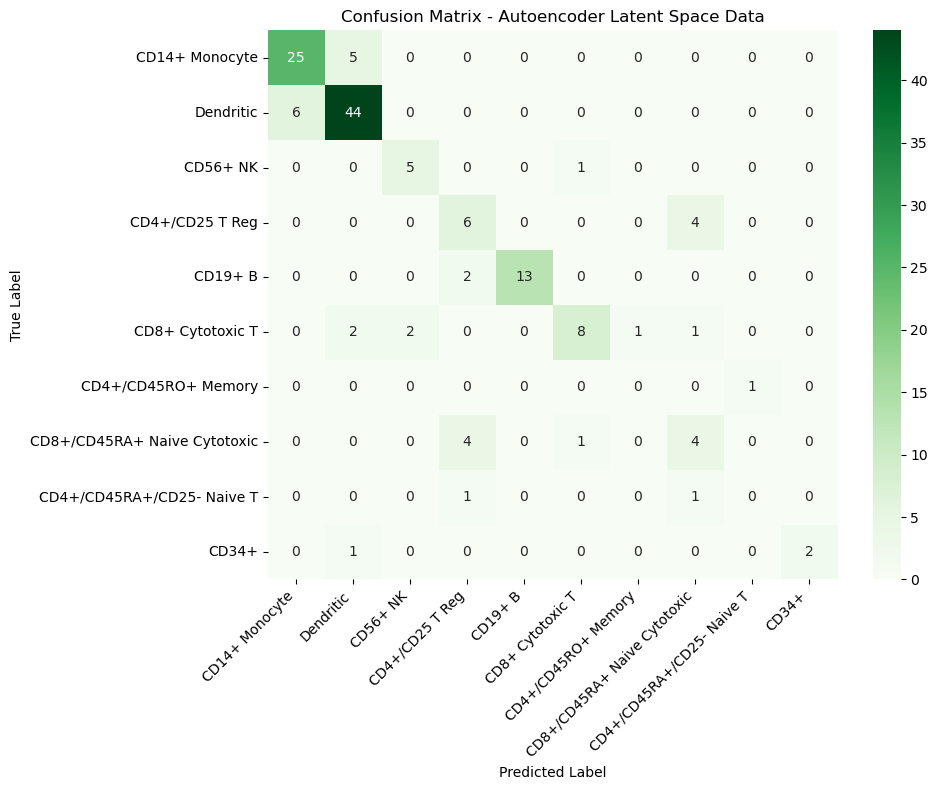

In [10]:
if can_run_latent_classification and X_train_latent.size > 0 : # Added check for non-empty latent data
    print("\nTraining Random Forest on Autoencoder Latent Space Data")
    # Initialize the Random Forest Classifier
    rf_classifier_latent = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

    # Train the classifier
    rf_classifier_latent.fit(X_train_latent, y_train_int)
    print("Random Forest training on latent space data complete.")

    # Make predictions on the test set
    y_pred_latent = rf_classifier_latent.predict(X_test_latent)

    # Evaluate the classifier
    accuracy_latent = accuracy_score(y_test_int, y_pred_latent)
    print(f"\nAccuracy on Autoencoder Latent Space Data: {accuracy_latent:.4f}")

    print("\nClassification Report on Autoencoder Latent Space Data:")
    class_report_latent = classification_report(y_test_int, y_pred_latent, target_names=categories, zero_division=0)
    print(class_report_latent)

    # Confusion Matrix
    print("\nConfusion Matrix on Autoencoder Latent Space Data:")
    cm_latent = confusion_matrix(y_test_int, y_pred_latent)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_latent, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix - Autoencoder Latent Space Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipped Random Forest on Autoencoder Latent Space Data due to missing/failed loading of 'final_encoder'/'scaler_final' or empty latent data.")

In [11]:
from sklearn.model_selection import GridSearchCV
print("\nHyperparameter Tuning for Random Forest")

param_grid_rf = {
    'n_estimators': [100, 200, 300],       # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],       # Minimum number of samples required to be at a leaf node
}


Hyperparameter Tuning for Random Forest



--- Tuning Random Forest for Original Scaled Data ---
Starting GridSearchCV for original data (this may take some time)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_es

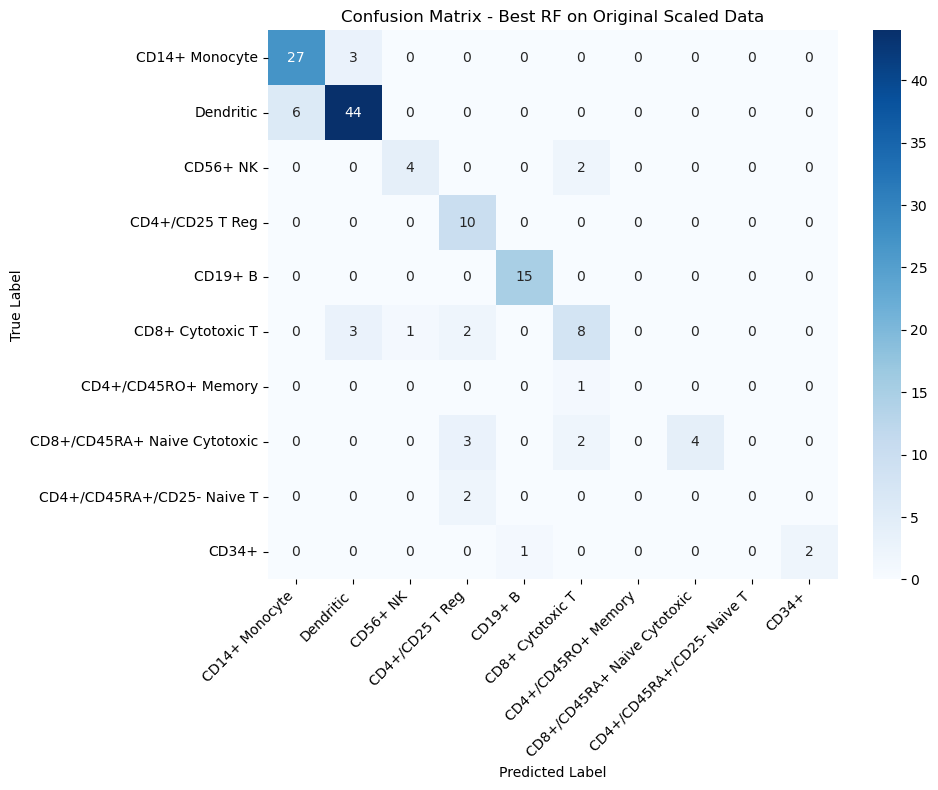

In [ ]:
print("\n--- Tuning Random Forest for Original Scaled Data ---")
grid_search_orig = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                                param_grid=param_grid_rf,
                                cv=3,
                                n_jobs=-1,
                                verbose=2,
                                scoring='accuracy')

# Fit GridSearchCV
print("Starting GridSearchCV for original data")
grid_search_orig.fit(X_train_scaled_orig, y_train_int)

# Get the best parameters and the best estimator
best_params_orig = grid_search_orig.best_params_
best_rf_orig = grid_search_orig.best_estimator_
print(f"\nBest parameters for original data: {best_params_orig}")
print(f"Best cross-validation accuracy for original data: {grid_search_orig.best_score_:.4f}")

# Evaluate the best model on the test set
y_pred_best_orig = best_rf_orig.predict(X_test_scaled_orig)
accuracy_best_orig = accuracy_score(y_test_int, y_pred_best_orig)
print(f"\nTest Accuracy with Best RF on Original Scaled Data: {accuracy_best_orig:.4f}")

print("\nClassification Report with Best RF on Original Scaled Data:")
class_report_best_orig = classification_report(y_test_int, y_pred_best_orig, target_names=categories, zero_division=0)
print(class_report_best_orig)

# Confusion Matrix for the best model
cm_best_orig = confusion_matrix(y_test_int, y_pred_best_orig)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best_orig, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Best RF on Original Scaled Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



--- Tuning Random Forest for Autoencoder Latent Space Data ---
Starting GridSearchCV for latent space data
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[C

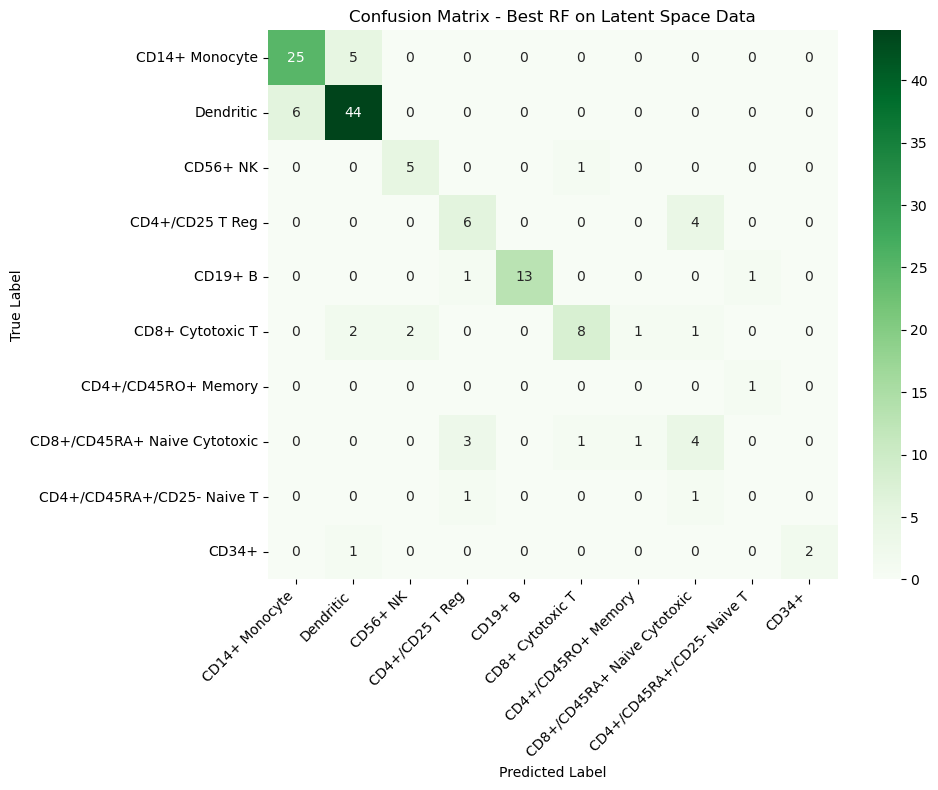

In [13]:
if can_run_latent_classification and X_train_latent.size > 0:
    print("\n\n--- Tuning Random Forest for Autoencoder Latent Space Data ---")
    grid_search_latent = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                                      param_grid=param_grid_rf, # Using the same param_grid
                                      cv=3,
                                      n_jobs=-1,
                                      verbose=2,
                                      scoring='accuracy')

    print("Starting GridSearchCV for latent space data")
    grid_search_latent.fit(X_train_latent, y_train_int)

    best_params_latent = grid_search_latent.best_params_
    best_rf_latent = grid_search_latent.best_estimator_
    print(f"\nBest parameters for latent space data: {best_params_latent}")
    print(f"Best cross-validation accuracy for latent space data: {grid_search_latent.best_score_:.4f}")

    y_pred_best_latent = best_rf_latent.predict(X_test_latent)
    accuracy_best_latent = accuracy_score(y_test_int, y_pred_best_latent)
    print(f"\nTest Accuracy with Best RF on Latent Space Data: {accuracy_best_latent:.4f}")

    print("\nClassification Report with Best RF on Latent Space Data:")
    class_report_best_latent = classification_report(y_test_int, y_pred_best_latent, target_names=categories, zero_division=0)
    print(class_report_best_latent)

    # Confusion Matrix for the best model on latent data
    cm_best_latent = confusion_matrix(y_test_int, y_pred_best_latent)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_best_latent, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix - Best RF on Latent Space Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("\n\nSkipped Hyperparameter Tuning for Latent Space Data due to missing artifacts or empty latent data.")

In [14]:
print("\nKeras Neural Network Classifier")

# Ensure y_train and y_test are correct
if 'y_train' not in globals() or y_train.ndim != 2 or y_train.shape[1] != num_classes:
    raise ValueError("y_train is not correct. Check data loading.")
if 'y_test' not in globals() or y_test.ndim != 2 or y_test.shape[1] != num_classes:
    raise ValueError("y_test is not correct. Check data loading.")


def build_nn_classifier(input_shape, num_classes_nn):
    """Builds a simple Keras feed-forward neural network for classification."""
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3), # Dropout
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes_nn, activation='softmax') # Softmax 
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Define EarlyStopping callback
nn_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)


Keras Neural Network Classifier



--- Training Neural Network on Original Scaled Data ---
NN Model Summary (Original Data):


/home/nathan/miniconda3/envs/bioe245_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,954 (417.79 KB)

 Trainable params: 106,954 (417.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2856 - loss: 2.1290 - val_accuracy: 0.4464 - val_loss: 1.5732
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3947 - loss: 1.5935 - val_accuracy: 0.6071 - val_loss: 1.1705
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5930 - loss: 1.1679 - val_accuracy: 0.6429 - val_loss: 0.9800
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6995 - loss: 0.9572 - val_accuracy: 0.6607 - val_loss: 0.8835
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7662 - loss: 0.7298 - val_accuracy: 0.7143 - val_loss: 0.7976
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8232 - loss: 0.5579 - val_accuracy: 0.7143 - val_loss: 0.7554
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8471 - loss: 0.5086 - val_accuracy: 0.7500 - val_loss: 0.7194
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8472 - loss: 0.4636 - val_accuracy: 0.7321 - val_loss: 0.

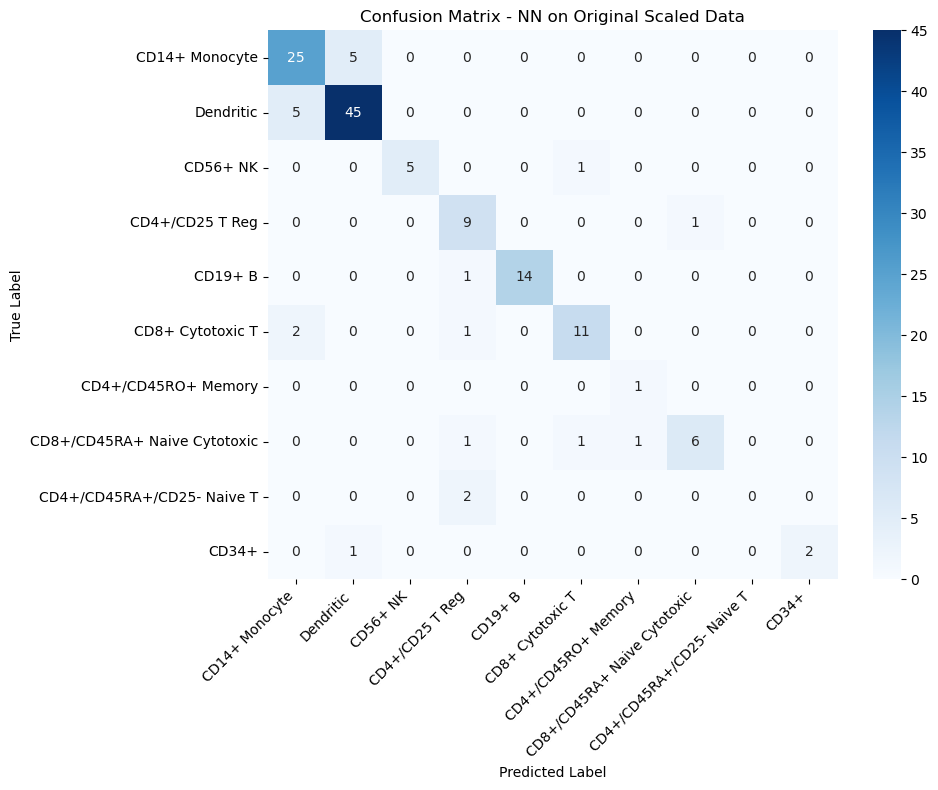

In [15]:
print("\n--- Training Neural Network on Original Scaled Data ---")
input_shape_orig = (X_train_scaled_orig.shape[1],)
nn_classifier_orig = build_nn_classifier(input_shape_orig, num_classes)
print("NN Model Summary (Original Data):")
nn_classifier_orig.summary()

history_nn_orig = nn_classifier_orig.fit(
    X_train_scaled_orig, y_train,
    epochs=100,    
    batch_size=32,
    validation_split=0.1,        # Use 10% of training data 
    callbacks=[nn_early_stopping],
    verbose=1
)

# Evaluate
loss_nn_orig, accuracy_nn_orig = nn_classifier_orig.evaluate(X_test_scaled_orig, y_test, verbose=0)
print(f"\nTest Accuracy with NN on Original Scaled Data: {accuracy_nn_orig:.4f}")

# Get predictions 
y_pred_proba_nn_orig = nn_classifier_orig.predict(X_test_scaled_orig)
y_pred_nn_orig = np.argmax(y_pred_proba_nn_orig, axis=1) # Convert probabilities to integer

print("\nClassification Report with NN on Original Scaled Data:")
class_report_nn_orig = classification_report(y_test_int, y_pred_nn_orig, target_names=categories, zero_division=0)
print(class_report_nn_orig)

#Confusion Matrix
cm_nn_orig = confusion_matrix(y_test_int, y_pred_nn_orig)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nn_orig, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - NN on Original Scaled Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



--- Training Neural Network on Autoencoder Latent Space Data ---
NN Model Summary (Latent Space Data):


/home/nathan/miniconda3/envs/bioe245_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,226 (67.29 KB)

 Trainable params: 17,226 (67.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2819 - loss: 2.1378 - val_accuracy: 0.5714 - val_loss: 1.6447
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6054 - loss: 1.5267 - val_accuracy: 0.5714 - val_loss: 1.1341
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6351 - loss: 1.0611 - val_accuracy: 0.6250 - val_loss: 0.9938
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6883 - loss: 0.8835 - val_accuracy: 0.6429 - val_loss: 0.9262
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6942 - loss: 0.8010 - val_accuracy: 0.6429 - val_loss: 0.8841
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6752 - loss: 0.7730 - val_accuracy: 0.7143 - val_loss: 0.8760
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7145 - loss: 0.7118 - val_accuracy: 0.6964 - val_loss: 0.8641
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6735 - loss: 0.7412 - val_accuracy: 0.7321 - 

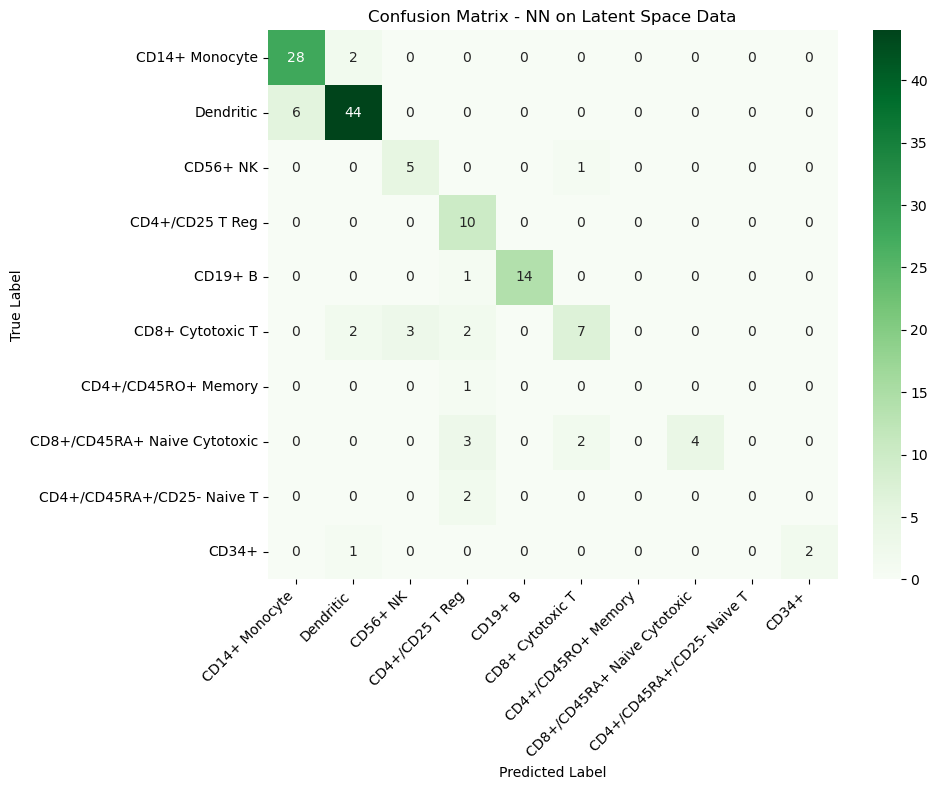

In [16]:
if can_run_latent_classification and X_train_latent.size > 0:
    print("\n\n--- Training Neural Network on Autoencoder Latent Space Data ---")
    input_shape_latent = (X_train_latent.shape[1],)
    nn_classifier_latent = build_nn_classifier(input_shape_latent, num_classes)
    print("NN Model Summary (Latent Space Data):")
    nn_classifier_latent.summary()

    history_nn_latent = nn_classifier_latent.fit(
        X_train_latent, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[nn_early_stopping],
        verbose=1
    )

    loss_nn_latent, accuracy_nn_latent = nn_classifier_latent.evaluate(X_test_latent, y_test, verbose=0)
    print(f"\nTest Accuracy with NN on Latent Space Data: {accuracy_nn_latent:.4f}")

    y_pred_proba_nn_latent = nn_classifier_latent.predict(X_test_latent)
    y_pred_nn_latent = np.argmax(y_pred_proba_nn_latent, axis=1)

    print("\nClassification Report with NN on Latent Space Data:")
    class_report_nn_latent = classification_report(y_test_int, y_pred_nn_latent, target_names=categories, zero_division=0)
    print(class_report_nn_latent)
    
    cm_nn_latent = confusion_matrix(y_test_int, y_pred_nn_latent)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_nn_latent, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix - NN on Latent Space Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("\n\nSkipped Latent Space Data due to missing data.")

In [17]:
print("\n--- Hyperparameter Tuning for Keras Neural Network Classifier ---")

# Ensure y_train and y_test are in one-hot format for Keras
if 'y_train' not in globals() or y_train.ndim != 2 or y_train.shape[1] != num_classes:
    raise ValueError("y_train is not correct. Check data loading.")
if 'y_test' not in globals() or y_test.ndim != 2 or y_test.shape[1] != num_classes:
    raise ValueError("y_test is correct. Check data loading.")

def build_model_for_tuner(hp, input_shape_tuner, num_classes_tuner):
    """Builds a Keras model with tunable hyperparameters."""
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape_tuner)) # Explicit Input layer

    # Tune the number of units in the first Dense layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(layers.Dense(units=hp_units_1, activation='relu'))
    # Tune dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(rate=hp_dropout_1))

    # Tune the number of units in the second Dense layer
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    model.add(layers.Dense(units=hp_units_2, activation='relu'))
    # Tune dropout rate
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(rate=hp_dropout_2))
    
    model.add(layers.Dense(num_classes_tuner, activation='softmax'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define EarlyStopping callback for tuner search
tuner_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False, verbose=0) # patience reduced

# Tuning NN for Original Scaled Data
print("\nTuning Keras NN for Original Scaled Data")
input_shape_orig_tuner = (X_train_scaled_orig.shape[1],)

tuner_orig = kt.RandomSearch(
    lambda hp: build_model_for_tuner(hp, input_shape_tuner=input_shape_orig_tuner, num_classes_tuner=num_classes),
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to test 
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='pbmc_nn_orig_tuning',
    overwrite=True # Set to False to resume a previous search
)

print("Starting Keras Tuner search for original data")
tuner_orig.search(X_train_scaled_orig, y_train, epochs=50, validation_split=0.2, callbacks=[tuner_early_stopping], verbose=1)

# Get the optimal hyperparameters
best_hps_orig = tuner_orig.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest hyperparameters for original data: {best_hps_orig.values}")

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.857142835855484

Best val_accuracy So Far: 0.8616071343421936
Total elapsed time: 00h 01m 25s

Best hyperparameters for original data: {'units_1': 256, 'dropout_1': 0.30000000000000004, 'units_2': 96, 'dropout_2': 0.2, 'learning_rate': 0.001}



Training the best NN model (original data) on full training data...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2606 - loss: 2.0742 - val_accuracy: 0.5179 - val_loss: 1.3214
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6247 - loss: 1.1717 - val_accuracy: 0.6786 - val_loss: 0.9767
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7480 - loss: 0.7369 - val_accuracy: 0.7321 - val_loss: 0.8260
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8167 - loss: 0.5568 - val_accuracy: 0.6964 - val_loss: 0.7242
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8632 - loss: 0.4110 - val_accuracy: 0.7321 - val_loss: 0.6914
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9326 - loss: 0.2736 - val_accuracy: 0.7143 - val_loss: 0.6264
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9302 - loss: 0.2692 - val_accuracy: 0.7857 - val_loss: 0.6057
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

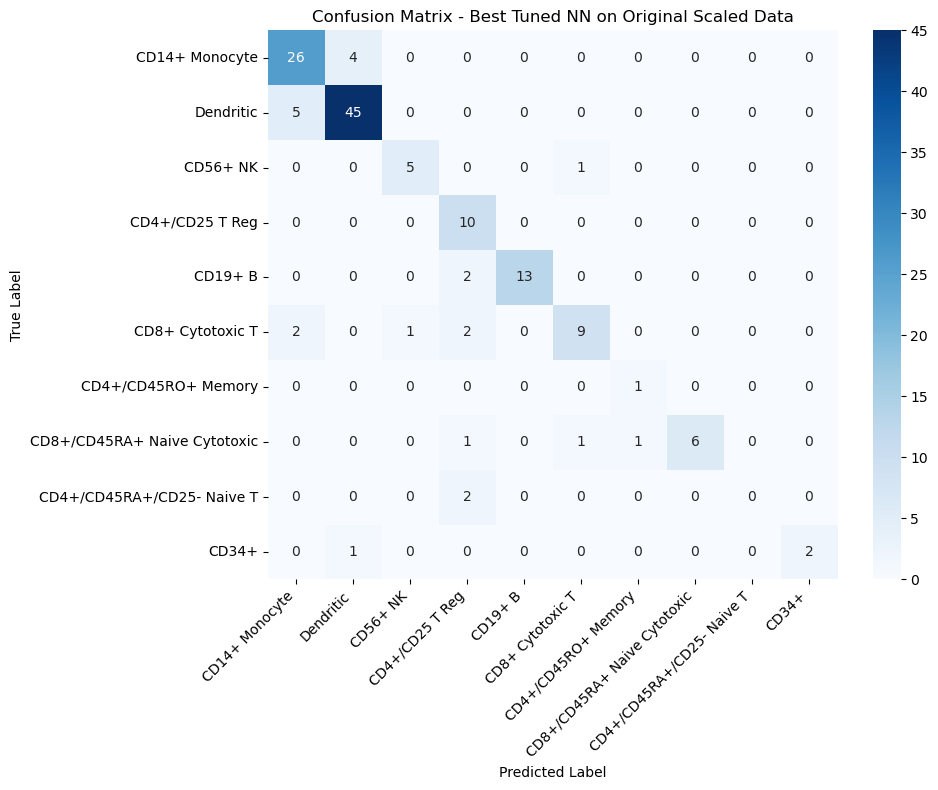

In [18]:
best_nn_model_orig = tuner_orig.hypermodel.build(best_hps_orig)
print("\nTraining the best NN model (original data) on full training data...")
history_best_nn_orig = best_nn_model_orig.fit(
    X_train_scaled_orig, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1, # Use a small validation split for this final training run
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)],
    verbose=1
)

# Evaluate the best model on the test set
loss_best_nn_orig, accuracy_best_nn_orig = best_nn_model_orig.evaluate(X_test_scaled_orig, y_test, verbose=0)
print(f"\nTest Accuracy with Best Tuned NN on Original Scaled Data: {accuracy_best_nn_orig:.4f}")

y_pred_proba_best_nn_orig = best_nn_model_orig.predict(X_test_scaled_orig)
y_pred_best_nn_orig = np.argmax(y_pred_proba_best_nn_orig, axis=1)

print("\nClassification Report with Best Tuned NN on Original Scaled Data:")
print(classification_report(y_test_int, y_pred_best_nn_orig, target_names=categories, zero_division=0))

cm_best_nn_orig = confusion_matrix(y_test_int, y_pred_best_nn_orig)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best_nn_orig, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Best Tuned NN on Original Scaled Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Trial 10 Complete [00h 00m 05s]
val_accuracy: 0.8080357015132904

Best val_accuracy So Far: 0.8125
Total elapsed time: 00h 01m 05s

Best hyperparameters for latent space data: {'units_1': 32, 'dropout_1': 0.1, 'units_2': 32, 'dropout_2': 0.2, 'learning_rate': 0.01}

Training the best NN model (latent space data) on full training data...


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3928 - loss: 1.8088 - val_accuracy: 0.6786 - val_loss: 0.9712
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6855 - loss: 0.8791 - val_accuracy: 0.7321 - val_loss: 0.9452
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7260 - loss: 0.6910 - val_accuracy: 0.7500 - val_loss: 0.8785
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7553 - loss: 0.6390 - val_accuracy: 0.7500 - val_loss: 0.8236
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7601 - loss: 0.6387 - val_accuracy: 0.7500 - val_loss: 0.8234
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7094 - loss: 0.6650 - val_accuracy: 0.7143 - val_loss: 0.8449
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7485 - loss: 0.6946 - val_accuracy: 0.7679 - val_loss: 0.7622
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7692 - loss: 0.6188 - val_accuracy: 0.7857 - 

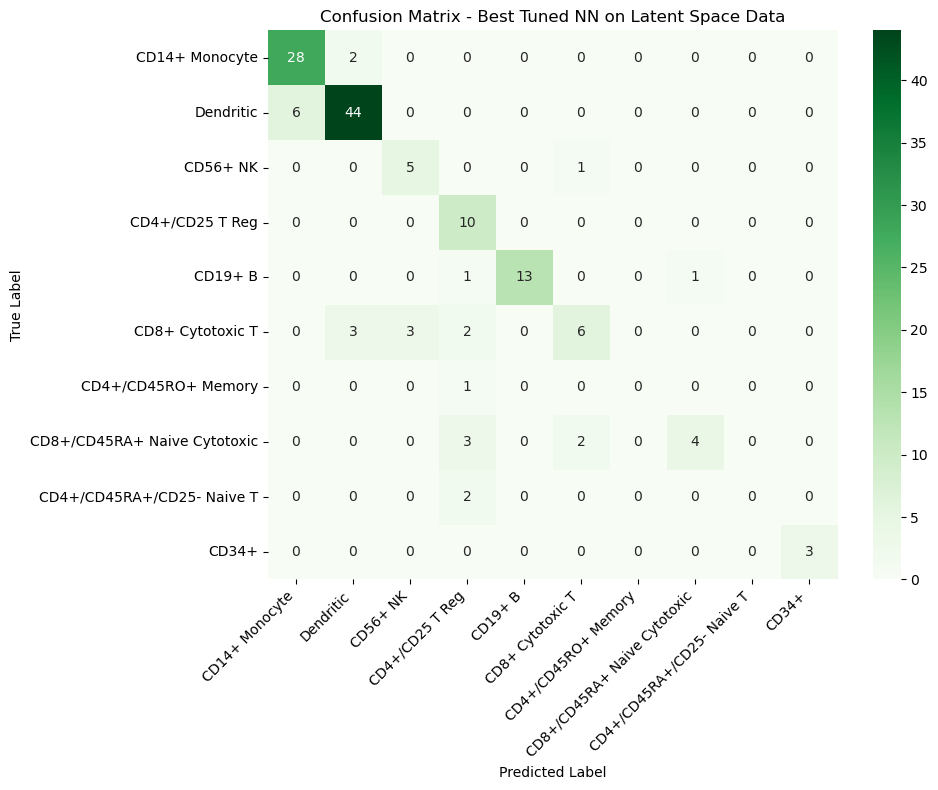

In [19]:
if can_run_latent_classification and X_train_latent.size > 0:
    print("\n\n--- Tuning Keras NN for Autoencoder Latent Space Data ---")
    input_shape_latent_tuner = (X_train_latent.shape[1],)

    tuner_latent = kt.RandomSearch(
        lambda hp: build_model_for_tuner(hp, input_shape_tuner=input_shape_latent_tuner, num_classes_tuner=num_classes),
        objective='val_accuracy',
        max_trials=10, # Increase for more thorough search
        executions_per_trial=2,
        directory='keras_tuner_dir',
        project_name='pbmc_nn_latent_tuning',
        overwrite=True
    )
    
    print("Starting Keras Tuner search for latent space data (this may take some time)...")
    tuner_latent.search(X_train_latent, y_train, epochs=50, validation_split=0.2, callbacks=[tuner_early_stopping], verbose=1)

    best_hps_latent = tuner_latent.get_best_hyperparameters(num_trials=1)[0]
    print(f"\nBest hyperparameters for latent space data: {best_hps_latent.values}")

    best_nn_model_latent = tuner_latent.hypermodel.build(best_hps_latent)
    print("\nTraining the best NN model (latent space data) on full training data...")
    history_best_nn_latent = best_nn_model_latent.fit(
        X_train_latent, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)],
        verbose=1
    )

    loss_best_nn_latent, accuracy_best_nn_latent = best_nn_model_latent.evaluate(X_test_latent, y_test, verbose=0)
    print(f"\nTest Accuracy with Best Tuned NN on Latent Space Data: {accuracy_best_nn_latent:.4f}")

    y_pred_proba_best_nn_latent = best_nn_model_latent.predict(X_test_latent)
    y_pred_best_nn_latent = np.argmax(y_pred_proba_best_nn_latent, axis=1)

    print("\nClassification Report with Best Tuned NN on Latent Space Data:")
    print(classification_report(y_test_int, y_pred_best_nn_latent, target_names=categories, zero_division=0))

    cm_best_nn_latent = confusion_matrix(y_test_int, y_pred_best_nn_latent)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_best_nn_latent, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix - Best Tuned NN on Latent Space Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("\n\nSkipped Keras Tuner for Latent Space Data due to missing artifacts or empty latent data.")

In [ ]:
model_to_save = nn_classifier_orig 
scaler_to_save = scaler_original_data 
model_description = "feed_forward_nn_original_data"
    
model_filename = f"{model_description}.keras"
scaler_filename = f"scaler_for_{model_description}.joblib"

model_to_save.save(model_filename)
print(f"Saved Keras NN model to: {model_filename}")

joblib.dump(scaler_to_save, scaler_filename)

Saved Keras NN model to: feed_forward_nn_original_data.keras
Saved corresponding scaler to: scaler_for_feed_forward_nn_original_data.joblib

To load for inference:
  loaded_model = keras.models.load_model('feed_forward_nn_original_data.keras')
  loaded_scaler = joblib.load('scaler_for_feed_forward_nn_original_data.joblib')
  new_data_scaled = loaded_scaler.transform(new_data_raw)
  predictions = loaded_model.predict(new_data_scaled)
